### AutoEncoder PyTorch Demo using MNIST

In this demo, we build a simple autoencoder using PyTorch. A separate encoder and decoder are built. The encoder is trained to encode the input data into a latent space. The decoder is trained to reconstruct the input data from the latent space.

This demo also shows how to use an autoencoder to remove noise from images.

In [2]:
import torch
import torchvision
import wandb
import time

from torch import nn
from einops import rearrange
from argparse import ArgumentParser
from pytorch_lightning import LightningModule, Trainer, Callback
from pytorch_lightning.loggers import WandbLogger
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

2022-05-29 08:49:41.025216: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


#### CNN Encoder using PyTorch

We use 3 CNN layers to encode the input image. We use stride of 2 to reduce the feature map size. The last MLP layer resizes the flattened feature map to the target latent vector size, `feature_dim`.


In [3]:
class Encoder(nn.Module):
    def __init__(self, n_features=1, kernel_size=3, n_filters=16, feature_dim=16):
        super().__init__()
        self.conv1 = nn.Conv2d(n_features, n_filters, kernel_size=kernel_size, stride=2)
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, kernel_size=kernel_size, stride=2)
        self.conv3 = nn.Conv2d(n_filters*2, n_filters*4, kernel_size=kernel_size, stride=2)
        self.fc1 = nn.Linear(256, feature_dim)
        
    def forward(self, x):
        y = nn.ReLU()(self.conv1(x))
        y = nn.ReLU()(self.conv2(y))
        y = nn.ReLU()(self.conv3(y))
        y = rearrange(y, 'b c h w -> b (c h w)')

        y = self.fc1(y)
        return y


# use this to get the correct input shape for  fc1. 
encoder = Encoder(n_features=1)
x = torch.Tensor(1, 1, 28, 28)
h = encoder(x)
print("h.shape:", h.shape)

h.shape: torch.Size([1, 16])


### CNN Decoder using PyTorch

A decoder is used to reconstruct the input image. The decoder is trained to reconstruct the input data from the latent space. The architecture is similar to the encoder but inverted. A latent vector is resized using an MLP layer so that it is suitable for a convolutional layer. We use strided tranposed convolutional layers to upsample the feature map until the desired image size is reached. The last activation layer is a sigmoid to ensure the output is in the range [0, 1].

In [4]:
class Decoder(nn.Module):
    def __init__(self, kernel_size=3, n_filters=64, feature_dim=16, output_size=28, output_channels=1):
        super().__init__()
        self.init_size = output_size // 2**2 - 1
        self.fc1 = nn.Linear(feature_dim, self.init_size**2 * n_filters)
        # output size of conv2dtranspose is (h-1)*2 + 1 + (kernel_size - 1)
        self.conv1 = nn.ConvTranspose2d(n_filters, n_filters//2, kernel_size=kernel_size, stride=2)
        self.conv2 = nn.ConvTranspose2d(n_filters//2, n_filters//4, kernel_size=kernel_size, stride=2)
        self.conv3 = nn.ConvTranspose2d(n_filters//4, output_channels, kernel_size=kernel_size-1)
        
    def forward(self, x):
        B, _ = x.shape
        y = self.fc1(x)
        y = rearrange(y, 'b (c h w) -> b c h w', b=B, h=self.init_size, w=self.init_size)
        y = nn.ReLU()(self.conv1(y))
        y = nn.ReLU()(self.conv2(y))
        y = nn.Sigmoid()(self.conv3(y))

        return y

decoder = Decoder()
x_tilde = decoder(h)
print("x_tilde.shape:", x_tilde.shape)

x_tilde.shape: torch.Size([1, 1, 28, 28])


#### PyTorch Lightning AutoEncoder

An autoencoder is simply an encoder and a decoder. The encoder extracts the feature vector from the input image. The decoder reconstructs the input image from the feature vector. The feature vector is the compressed representation of the input image.

Our PL module can also perform denoising. Below, we also present the collate function for clean and noisy images. To generate noisy images, we apply a Gaussian noise with mean of 0.5 and a standard deviation of 0.5.

In [5]:
def noise_collate_fn(batch):
        x, _ = zip(*batch)
        x = torch.stack(x, dim=0)
        # mean=0.5, std=0.5 normal noise
        noise = torch.normal(0.5, 0.5, size=x.shape)
        xn = x + noise
        xn = torch.clamp(xn, 0, 1)
        return xn, x

def clean_collate_fn(batch):
        x, _ = zip(*batch)
        x = torch.stack(x, dim=0)
        return x, x

class LitAEMNISTModel(LightningModule):
    def __init__(self, feature_dim=16, lr=0.001, batch_size=64,
                 num_workers=4, max_epochs=30, denoise=False, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(feature_dim=feature_dim)
        self.decoder = Decoder(feature_dim=feature_dim)
        self.loss = nn.MSELoss()
        self.denoise = denoise

    def forward(self, x):
        h = self.encoder(x)
        x_tilde = self.decoder(h)
        return x_tilde

    # this is called during fit()
    def training_step(self, batch, batch_idx):
        x_in, x = batch
        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        return {"loss": loss}

    # calls to self.log() are recorded in wandb
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("train_loss", avg_loss, on_epoch=True)

    # this is called at the end of an epoch
    def test_step(self, batch, batch_idx):
        x_in, x = batch
        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        return {"x_in" : x_in, "x_tilde" : x_tilde, "test_loss" : loss,}

    # this is called at the end of all epochs
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)

    # validation is the same as test
    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        return self.test_epoch_end(outputs)

    # we use Adam optimizer
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        # this decays the learning rate to 0 after max_epochs using cosine annealing
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler]
    
    # this is called after model instatiation to initiliaze the datasets and dataloaders
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

    # build train and test dataloaders using MNIST dataset
    # we use simple ToTensor transform
    def train_dataloader(self):        
        collate_fn = noise_collate_fn if self.denoise else clean_collate_fn
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                "./data", train=True, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=collate_fn
        )

    def test_dataloader(self):
        collate_fn = noise_collate_fn if self.denoise else clean_collate_fn
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                "./data", train=False, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=collate_fn
        )

    def val_dataloader(self):
        return self.test_dataloader()

#### Arguments

The arguments are as in our previous examples. The only new argument is `feature_dim`. This is the size of the latent vector. To use the denoising autoencoder, we also need to set `denoise` to `True`.


In [6]:
def get_args():
    parser = ArgumentParser(description="PyTorch Lightning AE MNIST Example")
    parser.add_argument("--max-epochs", type=int, default=30, help="num epochs")
    parser.add_argument("--batch-size", type=int, default=64, help="batch size")
    parser.add_argument("--lr", type=float, default=0.001, help="learning rate")

    parser.add_argument("--feature-dim", type=int, default=2, help="ae feature dimension")
    # if denoise is true
    parser.add_argument("--denoise", action="store_true", help="train a denoising AE")

    parser.add_argument("--devices", default=1)
    parser.add_argument("--accelerator", default='gpu')
    parser.add_argument("--num-workers", type=int, default=4, help="num workers")
    
    args = parser.parse_args("")
    return args

#### Weights and Biases Callback

The callback logs train and validation metrics to `wandb`. It also logs sample predictions. This is similar to our `WandbCallback` example for MNIST.

In [7]:
class WandbCallback(Callback):

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        # process first 10 images of the first batch
        if batch_idx == 0:
            x, _ = batch
            n = 10
            outputs = outputs["x_tilde"]
            columns = ['image']
            if pl_module.denoise:
                columns += ['denoised']
                key = "mnist-ae-denoising"
            else:
                columns += ["reconstruction"]
                key = "mnist-ae-reconstruction"
            data = [[wandb.Image(x_i), wandb.Image(x_tilde_i)] for x_i, x_tilde_i in list(zip(x[:n], outputs[:n]))]
            wandb_logger.log_table(key=key, columns=columns, data=data)

#### Training an AE

We train the autoencoder on the MNIST dataset. For simple reconstruction, the input image is also the target image. For denoising, the input is the noisy image while the target is the clean image.

The results can be viewed on [wandb](https://app.wandb.ai/).

In [8]:
if __name__ == "__main__":
    args = get_args()
    ae = LitAEMNISTModel(feature_dim=args.feature_dim, lr=args.lr, 
                         batch_size=args.batch_size, num_workers=args.num_workers,
                         denoise=args.denoise, max_epochs=args.max_epochs)
    ae.setup()
   

In [9]:


    wandb_logger = WandbLogger(project="ae-mnist")
    start_time = time.time()
    trainer = Trainer(accelerator=args.accelerator,
                      devices=args.devices,
                      max_epochs=args.max_epochs,
                      logger=wandb_logger,
                      callbacks=[WandbCallback()])
    trainer.fit(ae)

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(elapsed_time))

    wandb.finish()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rowel. Use `wandb login --relogin` to force relogin
2022-05-29 08:49:47.276919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 23.8 K
1 | decoder | Decoder | 30.1 K
2 | loss    | MSELoss | 0     
------------------------------------
53.9 K    Trainable params
0         Non-trainable params
53.9 K    Total params
0.215     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Elapsed time: 363.13006234169006


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
epoch,30
test_loss,0.03919
train_loss,0.0385
trainer/global_step,28139


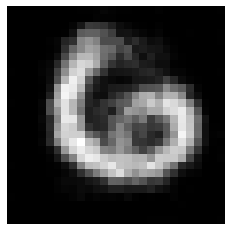

In [33]:
    # decoder as a generative model
    import matplotlib.pyplot as plt
    decoder = ae.decoder
    decoder.eval()
    with torch.no_grad():
        # generate a tensor of random noise with size 1, feature_dim
        x_in = torch.randn(1, args.feature_dim)
        x_tilde = decoder.forward(x_in)
        plt.imshow(x_tilde[0].detach().numpy().reshape(28, 28), cmap="gray")
        plt.axis('off')
        plt.show()